In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

from imblearn.keras import BalancedBatchGenerator

from clean_data import clean_data


Using TensorFlow backend.


## Part 2: Supervised Learning Model

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_train.shape

(42962, 367)

In [4]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

In [5]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### Get to know the data

In [7]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [8]:
clean_df = X

# Drop columns not in data dictionary
missing_from_feat_info = set(clean_df.columns.values).difference(feat_info.index.values)
clean_df.drop(list(missing_from_feat_info), axis='columns', inplace=True)

# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
clean_df[clean_df.isin(missing_values)] = np.nan

In [9]:
# Missing values by column
p_missing = (clean_df.isnull().sum() / clean_df.shape[0])
p_missing.sort_values(ascending=False).head(20)

TITEL_KZ          0.995042
KK_KUNDENTYP      0.589265
KBA05_BAUMAX      0.534891
AGER_TYP          0.439691
GEBURTSJAHR       0.406755
ALTER_HH          0.306713
W_KEIT_KIND_HH    0.242470
REGIOTYP          0.231134
KKK               0.231134
HH_DELTA_FLAG     0.225269
KBA05_KRSKLEIN    0.210209
KBA05_MOD4        0.210209
KBA05_MOD3        0.210209
KBA05_MOD2        0.210209
KBA05_MOD1        0.210209
KBA05_MAXSEG      0.210209
KBA05_MAXHERST    0.210209
KBA05_MAXBJ       0.210209
KBA05_MAXAH       0.210209
KBA05_KW3         0.210209
dtype: float64

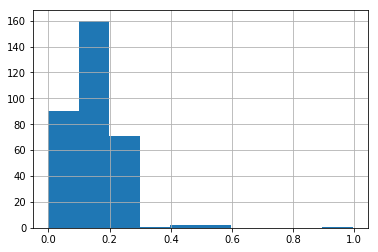

In [10]:
p_missing.hist();

In [66]:
to_drop = p_missing[p_missing >= .22]
to_drop

AGER_TYP          0.439691
ALTER_HH          0.306713
GEBURTSJAHR       0.406755
HH_DELTA_FLAG     0.225269
KBA05_BAUMAX      0.534891
KK_KUNDENTYP      0.589265
KKK               0.231134
REGIOTYP          0.231134
TITEL_KZ          0.995042
W_KEIT_KIND_HH    0.242470
dtype: float64

In [67]:
mailout_train_clean = mailout_train.drop(to_drop.index, axis=1)

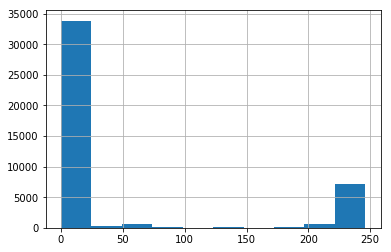

In [68]:
# Missing values by row
n_missing = mailout_train_clean.isnull().sum(axis=1)
n_missing.hist();

In [69]:
mailout_train_clean['RESPONSE'] = y

In [71]:
above_yes = mailout_train_clean[(n_missing > 10) & (mailout_train_clean.RESPONSE == 1)]
above_yes.head()

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
595,10758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,1
705,35317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1,1
810,13990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,1
1402,42791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1,2
2403,42734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,1


### Clean Data 

In [14]:
# Use cleaning function with no dropped rows
X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train))
print(X_clean.shape)
print(len(X_dropped))

(42962, 135)
0


### Preprocess

In [43]:
numeric = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
X_clean[numeric].head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,MIN_GEBAEUDEJAHR
0,15.0,0.0,0.0,1.0,13.0,0.0,1992.0
1,1.0,0.0,0.0,2.0,1.0,0.0,1994.0
2,NaN,NaN,0.0,0.0,1.0,0.0,1995.0
3,4.0,0.0,0.0,2.0,4.0,0.0,1992.0
4,53.0,0.0,0.0,1.0,44.0,0.0,1992.0


In [83]:
X_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,O,W,decade,movement,wealth,life_stage
0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5.0,2.0,...,3.0,3,2,4.0,0,1,40.0,0.0,3,4
1,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5.0,2.0,...,7.0,1,2,3.0,0,1,70.0,0.0,3,2
2,NaN,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2.0,4.0,...,2.0,3,1,4.0,1,0,40.0,1.0,1,4
3,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2.0,2.0,...,1.0,3,2,4.0,0,1,40.0,1.0,1,4
4,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7.0,6.0,...,3.0,3,1,3.0,0,1,50.0,0.0,4,1


In [85]:
X_clean.iloc[:5, 6]

0    3.0
1    2.0
2    4.0
3    4.0
4    3.0
Name: ARBEIT, dtype: float64

In [23]:
numerical_columns = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

categorical_columns = X_clean.columns.drop(numerical_columns)
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'))

preprocessor = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_columns),
     ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
    remainder='drop')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)

X_train = preprocessor.fit_transform(X_train)
print(X_train.shape)

X_test = preprocessor.transform(X_test)

(34369, 135)


### Model

In [86]:
def make_model(n_features):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=.0001),
                  metrics=['acc'])

    return model

In [93]:
def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator, epochs=65, verbose=False)
    return model

In [94]:
model = fit_predict_balanced_model(X_train, y_train, X_test, y_test)
y_pred = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.5395299359064141

## Part 3: Kaggle Competition

In [52]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
mailout_test.shape

(42833, 366)

In [55]:
LNR = mailout_test.LNR
LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [56]:
mailout_test, mailout_test_dropped = clean_data(mailout_test, feat_info, row_threshold=len(mailout_test))
mailout_test = preprocessor.transform(mailout_test)
test_pred = model.predict_proba(mailout_test)

In [71]:
pred = test_pred.flatten()
pred = pd.Series(np.where(pred > .5, 1, 0))
pred.head()

0    1
1    1
2    1
3    0
4    0
dtype: int32

In [79]:
submission = pd.DataFrame({'LNR':LNR, 'RESPONSE':pred})
submission.shape

(42833, 2)

In [78]:
submission.to_csv('pred1.csv', index=False)